## **Introduction**

One of the current trends between artificial intelligence and gaming environments is the implementation of deep reinforcement learning in ATARI games using the OpenAI GYM API. The OpenAI Gym is a toolkit to train the AI agent using reinforcement learning algorithms whereas ATARI 2600 is an iconic gaming console. It provided an challenging environment for testing and implementing reinforcement learning algorithms. Additionally, the project focuses on the challenging Pong and Space Invades environment, where it is set to train an AI agent to win the Atari game. The agent will take raw pixels from the Atari emulator and perform action predictions. The action will be further transmitted back to the emulator in the OpenAI interface. The deep reinforcement learning network used in ATARI Pong is the Rainbow algorithm, whereas both deep Q-network and double deep Q-network are used for ATARI Space Invaders. Nonetheless, the project aims to explore and compare the performance of the mentioned algorithms in different gaming environments. Moreover, it investigates each method's strengths and limitations to identify their adaptability to different challenges posed by ATARI games.





## **Problem Formulation**
The main problem formulation lies in achieving optimal gameplay for both ATARI games, Pong and Space Invaders. Below is the breakdown of the problem formulation.

**For ATARI Pong,**

***Problem Description:*** Utilizing the Pong environment as a multiplayer gaming scenario and aim to train AI agents that compete against each other and the computer.

***Problem Type:*** This constitutes a multiplayer reinforcement learning challenge wherein AI agents undergo training to excel in the Pong game, engaging in competitive play against both other AI agents and the computer.

***Dataset:*** The dataset encompasses game data from multiple Pong rounds, encompassing crucial information such as game states and associated rewards.

***Objective:*** The overarching goal is to equip AI agents with the prowess to outperform the computer AI and agents from other teams in Pong, with the ultimate objective of being the first to score 21 points.

***Evaluation Metric:*** Agent performance hinges on the rewards accrued during gameplay, with the winning agent being the one that attains a higher reward, signifying superior gameplay.

***Preprocessing Steps:*** To streamline the incoming game states, preprocessing involves converting RGB images to grayscale, scaling, and implementing necessary transformations.

***Methods and Algorithm Selection:*** The foundational model for this endeavor is the Raibow algorithm.

***Time and Resource Constraints:*** Given limitations in GPU availability, optimizing time and resources during the training phase is imperative.

***Expected Results:*** The anticipated outcome revolves around the successful training of AI agents adept at defeating both computer AI and counterparts from other teams in the game of Pong, achieved through the application of deep reinforcement learning. Performance assessment will be based on the agents' ability to secure higher scores and emerge victorious in the gameplay.

**For ATARI Space Invaders,**

***Problem Description:*** In this scenario, we leverage the SpaceInvaders-Atari2600 environment to train an AI agent proficient in playing the game of Space Invaders.

***Problem Type:*** This constitutes a reinforcement learning challenge wherein the primary objective is to train an AI agent, utilizing deep reinforcement learning techniques, to excel in achieving a high score in the Space Invaders game.

***Dataset:*** The dataset encompasses game data obtained from multiple rounds of gameplay within the SpaceInvaders-Atari2600 environment, inclusive of critical information such as game states and corresponding rewards.

***Objective:*** The overarching goal is to equip an AI agent with the capability to adeptly navigate the space, strategically engage with alien invaders, and maximize the in-game score in the Space Invaders game.

***Evaluation Metric:*** The performance of the agent is evaluated based on the accrued reward or score during gameplay. A higher score serves as an indicative measure of superior performance.

***Preprocessing Steps:*** To streamline incoming game states, preprocessing involves converting RGB images to grayscale, simplifying complexity, and applying necessary scaling and transformations.

***Methods and Algorithm Selection:*** The foundational model for this endeavor is the Deep Q-Network (DQN) algorithm and the Double Dueling Deep Q-Network (DDDQN)

***Time and Resource Constraints:*** In light of limitations in GPU availability and training time, efficient utilization of time and resources during the training phase remains a critical consideration.

***Expected Results:*** The anticipated outcome revolves around the successful training of an intelligent AI agent capable of navigating the spatial challenges, effectively engaging with alien invaders, and achieving a high score in the Space Invaders game. The agent's performance will be assessed based on its ability to maximize the in-game score.



**Main Library Used**

* OpenAi Gym


* PyTorch

* numpy

* opencv-python

* matplotlib

In [ ]:
import time
import gym
import random
import torch
import numpy as np
import torch.optim as optim
from collections import namedtuple, deque
import matplotlib.pyplot as plt
from IPython.display import clear_output
import torch.nn as nn
import torch.autograd as autograd
import torch.nn.functional as F
import math
import cv2


%matplotlib inline

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

Device:  cpu


## Viewing the environment of Space Invaders

In this setting, the observation consists of an RGB image representing the screen, presented as an array with dimensions (210, 160, 3). Each action is iteratively executed for a period of k frames, where k is randomly selected from the set {2, 3, 4}. The objective is to maximize the overall score.

In [ ]:
env = gym.make("SpaceInvaders-v0")
env.seed(0)

(2968811710, 3677149159)

The size of frame is:  (210, 160, 3)
No. of Actions:  6


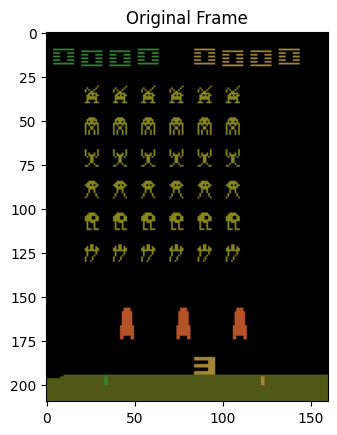

In [ ]:
print("The size of frame is: ", env.observation_space.shape)
print("No. of Actions: ", env.action_space.n)
env.unwrapped.get_action_meanings()
env.reset()
plt.figure()
plt.imshow(env.reset())
plt.title('Original Frame')
plt.show()

In [ ]:
def random_play():
    frames=[]
    score = 0
    env.reset()
    while True:
        env.render(mode='rgb_array')
        action = env.action_space.sample()
        state, reward, done, _ = env.step(action)
        score += reward
        frames.append(env.render(mode='rgb_array'))
        if done:
            env.close()
            print("The Score at end of game is: ", score)
            break
random_play()

The Score at end of game is:  45.0


## **Experiments**

Two deep reinforcement learning models, Deep Q-Network (DQN) and Double Dueling Deep Q-Network (DDDQN), are built to play the Space Invader Game. On the other hand, the rainbow algorithm is used to play the Pong Game. The performance of these models is compared and evaluated in the Discussion section.

**Huber Loss**

Huber loss is a regression loss function that combines properties of mean squared error (MSE) and mean absolute error (MAE). It is helpful in situations where data contain outliers and noise.
Due to its robustness, it can prevent the agent from being overly influenced by extreme events, which is helpful for the reinforcement agent to learn a policy that generalizes well to different states and situations.


In [ ]:
def huber_loss(input, target, beta=1, size_average=True):
    """
    very similar to the smooth_l1_loss from pytorch, but with
    the extra beta parameter
    """
    n = torch.abs(input - target)
    cond = n < beta
    loss = torch.where(cond, 0.5 * n ** 2 / beta, n - 0.5 * beta)
    if size_average:
        return loss.mean()
    return loss.sum()

 **Deep Q-Network (DQN)**

DQN is a reinforcement learning algorithm that combines deep neural networks with Q-learning. It uses an experience replay buffer to store and sample experiences (state, action, reward, next state) to break correlations in the sequence of experiences and improve learning stability. DQN
employs two separate neural networks - the online network (policy_net) and the target network (target_net). The target network's parameters are updated less frequently to stabilize the learning process. It balances exploration and exploitation using an epsilon-greedy strategy, where the agent chooses a random action with probability epsilon and the action with the maximum Q-value with probability 1 - epsilon.

The fundamental DQN algorithms comprises several layers, that is 3 convolutional layers, 1 flattening layer and two fully connect layers with specific input and output dimensions in different layers. Below is the detailed breakdown of the DQN architecture:

***Convolutional Layer 1:***Accepts input torch tensors of
size (4, 84, 84) and produces an output of size (32, 20, 20).

***Convolutional Layer 2***: Takes the output from the previous layer and generates a new output of size (64, 9, 9).

***Convolutional Layer 3:*** Takes the output from the second layer and produces a further output of size (64, 7, 7).

***Flatten Layer:*** Reshapes the tensor to (-1, 64 * 7 * 7), effectively flattening it.

***Fully Connected Layer 1:*** Takes the flattened tensor with 64 * 7 * 7 nodes as input and yields an output of 512 nodes.

***Fully Connected Layer 2:*** Takes the output from the previous layer and produces an output with the number of nodes equal to the number of actions.





In [ ]:
class DQNCnn(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(DQNCnn, self).__init__()
        self.input_shape = input_shape
        self.num_actions = num_actions

        self.features = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        self.fc = nn.Sequential(
            nn.Linear(self.feature_size(), 512),
            nn.ReLU(),
            nn.Linear(512, self.num_actions)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    def feature_size(self):
        return self.features(autograd.Variable(torch.zeros(1, *self.input_shape))).view(1, -1).size(1)

In [ ]:
class DQNAgent():
    def __init__(self, input_shape, action_size, seed, device, buffer_size, batch_size, gamma, lr, tau, update_every, replay_after, model):
        """Initialize an Agent object.

        Params
        ======
            input_shape (tuple): dimension of each state (C, H, W)
            action_size (int): dimension of each action
            seed (int): random seed
            device(string): Use Gpu or CPU
            buffer_size (int): replay buffer size
            batch_size (int):  minibatch size
            gamma (float): discount factor
            lr (float): learning rate
            update_every (int): how often to update the network
            replay_after (int): After which replay to be started
            model(Model): Pytorch Model
        """
        self.input_shape = input_shape
        self.action_size = action_size
        self.seed = random.seed(seed)
        self.device = device
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.gamma = gamma
        self.lr = lr
        self.update_every = update_every
        self.replay_after = replay_after
        self.DQN = model
        self.tau = tau


        # Q-Network
        self.policy_net = self.DQN(input_shape, action_size).to(self.device)
        self.target_net = self.DQN(input_shape, action_size).to(self.device)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.lr)

        # Replay memory
        self.memory = ReplayBuffer(self.buffer_size, self.batch_size, self.seed, self.device)

        self.t_step = 0


    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)

        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % self.update_every

        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > self.replay_after:
                experiences = self.memory.sample()
                self.learn(experiences)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy."""

        state = torch.from_numpy(state).unsqueeze(0).to(self.device)
        self.policy_net.eval()
        with torch.no_grad():
            action_values = self.policy_net(state)
        self.policy_net.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences):
        states, actions, rewards, next_states, dones = experiences

        # Get expected Q values from policy model
        Q_expected_current = self.policy_net(states)
        Q_expected = Q_expected_current.gather(1, actions.unsqueeze(1)).squeeze(1)

        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.target_net(next_states).detach().max(1)[0]

        # Compute Q targets for current states
        Q_targets = rewards + (self.gamma * Q_targets_next * (1 - dones))

        # Compute loss
        loss = F.huber_loss(Q_expected, Q_targets)

        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.soft_update(self.policy_net, self.target_net, self.tau)


    # θ'=θ×τ+θ'×(1−τ)
    def soft_update(self, policy_model, target_model, tau):
        for target_param, policy_param in zip(target_model.parameters(), policy_model.parameters()):
            target_param.data.copy_(tau*policy_param.data + (1.0-tau)*target_param.data)

In [ ]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, buffer_size, batch_size, seed, device):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """

        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
        self.device = device

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.array([e.state for e in experiences if e is not None])).float().to(self.device)
        actions = torch.from_numpy(np.array([e.action for e in experiences if e is not None])).long().to(self.device)
        rewards = torch.from_numpy(np.array([e.reward for e in experiences if e is not None])).float().to(self.device)
        next_states = torch.from_numpy(np.array([e.next_state for e in experiences if e is not None])).float().to(self.device)
        dones = torch.from_numpy(np.array([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(self.device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

**Double Dueling Deep Q-Network (DDDQN)**

DDDQN is the combination of Double Deep Q-Network and Dueling Deep Q-Network. The DDQN uses two separate networks for action selection and Q-value estimation to address the overestimation bias in Q-value estimates encountered in traditional DQN. One network is used to select the best action, and another is used to estimate its Q-value. Instead of using the target network to estimate the Q-value of the next state and the online network to select the action, DDQN uses the online network to select the action and the target network to estimate its Q-value. While the dueling network architecture separates the Q-value estimation into two streams - the value stream and the advantage stream. This allows the model to estimate the value of being in a particular state independently of the advantage of taking each action in that state

The DDDQN architecture consists of 3 convolutional layer, 1 flatten layer, 4 fully connected layer and activation layer between each layer. Below is the detailed breakdown of the DDDQN architecture:


***Convolutional Layer 1:*** Accepts input torch tensors of
size (4, 84, 84) and produces an output of size (32, 20, 20).

***Convolutional Layer 2***: Takes the output from the previous layer and generates a new output of size (64, 9, 9).

***Convolutional Layer 3:*** Takes the output from the second layer and produces a further output of size (64, 7, 7).

***Flatten Layer:*** Reshapes the tensor to (-1, 64 * 7 * 7), effectively flattening it.

> For Advantage Stream:

***Fully Connected Layer 1:*** Takes the flattened tensor with 64 * 7 * 7 nodes as input and yields an output of 512 nodes.

***Fully Connected Layer 2:*** Takes the output from the previous layer and produces an output with the number of nodes equal to the number of actions.

> For Value Stream

***Fully Connected Layer 3:*** Fully connected layer with 512 nodes for the value stream

***Fully connected Layer 4:*** FUlly connected layer producing a single value representing the state value

In [ ]:
class DDDQNCnn(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(DDDQNCnn, self).__init__()
        self.input_shape = input_shape
        self.num_actions = num_actions

        self.features = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        self.advantage = nn.Sequential(
            nn.Linear(self.feature_size(), 512),
            nn.ReLU(),
            nn.Linear(512, self.num_actions)
        )

        self.value = nn.Sequential(
            nn.Linear(self.feature_size(), 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        advantage = self.advantage(x)
        value = self.value(x)
        return value + advantage  - advantage.mean()

    def feature_size(self):
        return self.features(autograd.Variable(torch.zeros(1, *self.input_shape))).view(1, -1).size(1)

In [ ]:
import torch.optim as optim
import random

class DDDQNAgent():
    def __init__(self, input_shape, action_size, seed, device, buffer_size, batch_size, gamma, lr, tau, update_every, replay_after, model):
        

        self.input_shape = input_shape
        self.action_size = action_size
        self.seed = random.seed(seed)
        self.device = device
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.gamma = gamma
        self.lr = lr
        self.update_every = update_every
        self.replay_after = replay_after
        self.DQN = model
        self.tau = tau


        # Q-Network
        self.online_net = self.DQN(input_shape, action_size).to(self.device)
        self.target_net = self.DQN(input_shape, action_size).to(self.device)
        self.optimizer = optim.Adam(self.online_net.parameters(), lr=self.lr)

        # Replay memory
        self.memory = ReplayBuffer(self.buffer_size, self.batch_size, self.seed, self.device)

        self.t_step = 0


    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)

        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % self.update_every

        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > self.replay_after:
                experiences = self.memory.sample()
                self.learn(experiences)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy."""

        state = torch.from_numpy(state).unsqueeze(0).to(self.device)
        self.online_net.eval()
        with torch.no_grad():
            action_values = self.online_net(state)
        self.online_net.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences):
        states, actions, rewards, next_states, dones = experiences

        # Get expected Q values from policy model
        Q_expected_current = self.online_net(states)
        Q_expected = Q_expected_current.gather(1, actions.unsqueeze(1)).squeeze(1)

        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.target_net(next_states).detach().max(1)[0]

        # Compute Q targets for current states
        Q_targets = rewards + (self.gamma * Q_targets_next * (1 - dones))

        # Compute loss
        # loss = F.mse_loss(Q_expected, Q_targets)
        loss = F.huber_loss(Q_expected, Q_targets)

        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.soft_update(self.online_net, self.target_net, self.tau)


    # θ'=θ×τ+θ'×(1−τ)
    def soft_update(self, policy_model, target_model, tau):
        for target_param, policy_param in zip(target_model.parameters(), policy_model.parameters()):
            target_param.data.copy_(tau*policy_param.data + (1.0-tau)*target_param.data)


## **Preprocessing**

The preprocessing step is done to reduce the state complexity in order to reduce the training computation time. The steps includes grayscaling each of our frames, croping the screen, normalizing pixel values, resize the preprocessed frame to 84*84. Lastly, stacking frames together

In [ ]:
def preprocess_frame(screen, exclude, output):
    """Preprocess Image.

        Params
        ======
            screen (array): RGB Image
            exclude (tuple): Section to be croped (UP, RIGHT, DOWN, LEFT)
            output (int): Size of output image
        """
    # TConver image to gray scale
    screen = cv2.cvtColor(screen, cv2.COLOR_RGB2GRAY)

    #Crop screen[Up: Down, Left: right]
    screen = screen[exclude[0]:exclude[2], exclude[3]:exclude[1]]

    # Convert to float, and normalized
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255

    # Resize image to 84 * 84
    screen = cv2.resize(screen, (output, output), interpolation = cv2.INTER_AREA)
    return screen

def stack_frame(stacked_frames, frame, is_new):
    """Stacking Frames.

        Params
        ======
            stacked_frames (array): Four Channel Stacked Frame
            frame: Preprocessed Frame to be added
            is_new: Is the state First
        """
    if is_new:
        stacked_frames = np.stack(arrays=[frame, frame, frame, frame])
        stacked_frames = stacked_frames
    else:
        stacked_frames[0] = stacked_frames[1]
        stacked_frames[1] = stacked_frames[2]
        stacked_frames[2] = stacked_frames[3]
        stacked_frames[3] = frame

    return stacked_frames

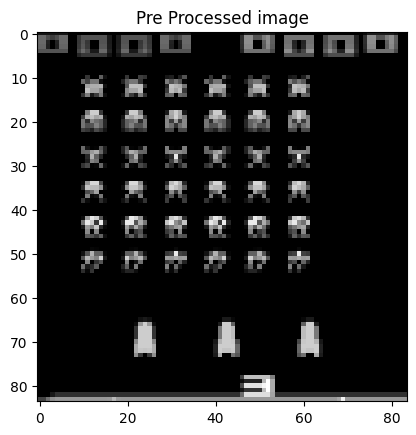

In [ ]:
env.reset()
plt.figure()
plt.imshow(preprocess_frame(env.reset(), (8, -12, -12, 4), 84), cmap="gray")
plt.title('Pre Processed image')
plt.show()

In [ ]:
def stack_frames(frames, state, is_new=False):
    frame = preprocess_frame(state, (30, -4, -12, 4), 84)
    frames = stack_frame(frames, frame, is_new)

    return frames

In [ ]:
def save_video(frame_array, savePath, fileName, fps, otype='AVI'):
    print('Creating replay', end=' ')
    if otype == 'AVI':
        fileName += '.avi'
        height, width, layers = frame_array[0].shape
        if layers == 1:
            layers = 0
        size = (width, height)
        out = cv2.VideoWriter(savePath + fileName, cv2.VideoWriter_fourcc(*'DIVX'), fps, size, layers)
        for i in range(len(frame_array)):
            out.write(frame_array[i])
        out.release()
        print('Done saving to {}'.format(savePath + fileName))
    else:
        print('Error: Invalid type.')

## Creating Agents

In [ ]:
# Set up hyperparamters
INPUT_SHAPE = (4, 84, 84)
ACTION_SIZE = env.action_space.n
SEED = 0
GAMMA = 0.99           # discount factor
BUFFER_SIZE = 100000   # replay buffer size
BATCH_SIZE = 64        # Update batch size
LR = 0.0001            # learning rate
TAU = 1e-3             # for soft update of target parameters
UPDATE_EVERY = 100       # how often to update the network
UPDATE_TARGET = 10000  # After which thershold replay to be started
EPS_START = 0.99       # starting value of epsilon
EPS_END = 0.01         # Ending value of epsilon
EPS_DECAY = 100         # Rate by which epsilon to be decayed

agent_dqn = DQNAgent(INPUT_SHAPE, ACTION_SIZE, SEED, device, BUFFER_SIZE, BATCH_SIZE, GAMMA, LR, TAU, UPDATE_EVERY, UPDATE_TARGET, DQNCnn)
agent_dddqn = DDDQNAgent(INPUT_SHAPE, ACTION_SIZE, SEED, device, BUFFER_SIZE, BATCH_SIZE, GAMMA, LR, TAU, UPDATE_EVERY, UPDATE_TARGET, DDDQNCnn)

## Training

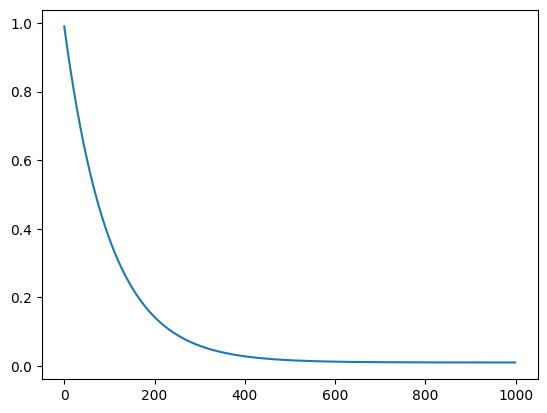

In [ ]:
epsilon_by_epsiode = lambda frame_idx: EPS_END + (EPS_START - EPS_END) * math.exp(-1. * frame_idx /EPS_DECAY)

plt.plot([epsilon_by_epsiode(i) for i in range(1000)])

**Explanation of result obtained above**

The plotted epsilon decay graph over 1000 episodes shows a smooth curve where the epsilon values decrease swiftly from 1.0 to 0.1 between episodes 0 to 200. This indicates that during the initial episodes, the DQN agent prioritizes exploration instead of exploitation. Hence, it is more likely for the agent to take random actions and explore the environment. From episodes 200 to 1000, the epsilon values decrease slowly from 0.1 to 0. This indicates that the DQN agent is shifting its focus to exploitation, selecting actions with greater estimated rewards.

In [ ]:
start_epoch = 0
scores = []
scores_window = deque(maxlen=20)

In [ ]:
def train_dqn(n_episodes=20000):
    """
    Params
    ======
        n_episodes (int): maximum number of training episodes
    """
    for i_episode in range(start_epoch + 1, n_episodes+1):
        state = stack_frames(None, env.reset(), True)
        score = 0
        eps = epsilon_by_epsiode(i_episode)
        while True:
            action = agent_dqn.act(state, eps)
            next_state, reward, done, info = env.step(action)
            next_state = stack_frames(state, next_state, False)
            agent_dqn.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score

        print('\rEpisode {}\tAverage Reward: {:.2f}\tEpsilon: {:.2f}'.format(i_episode, np.mean(scores_window), eps), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Reward: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if i_episode % 500 == 0:
            print(f"Saving weights at Episode {i_episode} ...")
            # torch.save(agent.onlinet_net.state_dict(), 'breakout.pth')
            torch.save(agent_dqn.policy_net.state_dict(), f"spaceinvaders_dqn_{i_episode}.pth")

    return scores

In [ ]:
scores_dqn = train_dqn(2000)

Episode 100	Average Reward: 195.25	Epsilon: 0.37
Episode 200	Average Reward: 212.75	Epsilon: 0.14
Episode 300	Average Reward: 174.75	Epsilon: 0.06
Episode 400	Average Reward: 265.50	Epsilon: 0.03
Episode 500	Average Reward: 279.75	Epsilon: 0.02
Saving weights at Episode 500 ...
Episode 600	Average Reward: 284.25	Epsilon: 0.01
Episode 700	Average Reward: 304.75	Epsilon: 0.01
Episode 800	Average Reward: 285.00	Epsilon: 0.01
Episode 900	Average Reward: 270.75	Epsilon: 0.01
Episode 1000	Average Reward: 229.75	Epsilon: 0.01
Saving weights at Episode 1000 ...
Episode 1100	Average Reward: 284.50	Epsilon: 0.01
Episode 1200	Average Reward: 262.75	Epsilon: 0.01
Episode 1300	Average Reward: 312.50	Epsilon: 0.01
Episode 1400	Average Reward: 291.75	Epsilon: 0.01
Episode 1500	Average Reward: 262.00	Epsilon: 0.01
Saving weights at Episode 1500 ...
Episode 1600	Average Reward: 300.50	Epsilon: 0.01
Episode 1700	Average Reward: 291.25	Epsilon: 0.01
Episode 1800	Average Reward: 275.75	Epsilon: 0.01
Episo

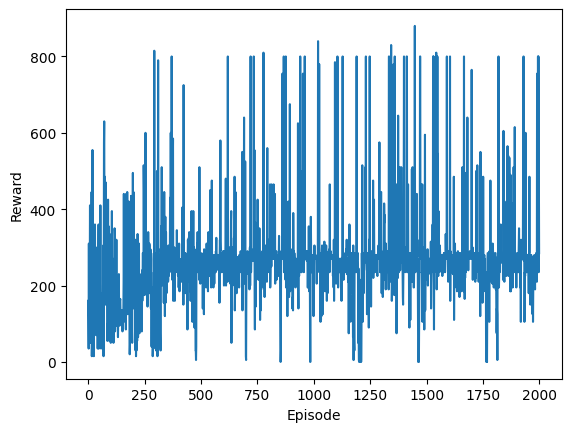

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores_dqn)), scores_dqn)
plt.ylabel('Reward')
plt.xlabel('Episode')
plt.show()

**Explanation of result obtained above**

It can be observed that the rewards obtained over episodes are heavily fluctuating. This suggests that the DQN agent is having difficulties learning how to play the Space Invader game.

In [ ]:
score = 0
frames = []
state = stack_frames(None, env.reset(), True)
while True:
    env.render(mode='rgb_array')
    action = agent_dqn.act(state, .01)
    next_state, reward, done, _ = env.step(action)
    score += reward
    state = stack_frames(state, next_state, False)
    frames.append(env.render(mode='rgb_array'))
    if done:
        print("The Final score is:", score)
        break
env.close()

The Final score is: 285.0


In [ ]:
fileName = 'SpaceInvaders_DQN'
save_video(frames, './', fileName, 60, otype='AVI')

Creating replay Done saving to ./SpaceInvaders_DQN.avi


## DDDQN_training

In [ ]:
start_epoch = 0
scores = []
scores_window = deque(maxlen=20)

In [ ]:
def train_dddqn(n_episodes=20000):
    """
    Params
    ======
        n_episodes (int): maximum number of training episodes
    """
    for i_episode in range(start_epoch + 1, n_episodes+1):
        state = stack_frames(None, env.reset(), True)
        score = 0
        eps = epsilon_by_epsiode(i_episode)
        while True:
            action = agent_dddqn.act(state, eps)
            next_state, reward, done, info = env.step(action)
            next_state = stack_frames(state, next_state, False)
            agent_dddqn.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score

        print('\rEpisode {}\tAverage Reward: {:.2f}\tEpsilon: {:.2f}'.format(i_episode, np.mean(scores_window), eps), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Reward: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if i_episode % 500 == 0:
            print(f"Saving weights at Episode {i_episode} ...")
            torch.save(agent_dddqn.online_net.state_dict(), f"spaceinvaders_dddqn_{i_episode}.pth")

    return scores

In [ ]:
scores_ddqn= train_dddqn(2000)

Episode 100	Average Reward: 211.00	Epsilon: 0.37
Episode 200	Average Reward: 206.75	Epsilon: 0.14
Episode 300	Average Reward: 237.25	Epsilon: 0.06
Episode 400	Average Reward: 260.00	Epsilon: 0.03
Episode 500	Average Reward: 257.75	Epsilon: 0.02
Saving weights at Episode 500 ...
Episode 600	Average Reward: 254.00	Epsilon: 0.01
Episode 700	Average Reward: 318.00	Epsilon: 0.01
Episode 800	Average Reward: 285.25	Epsilon: 0.01
Episode 900	Average Reward: 264.50	Epsilon: 0.01
Episode 1000	Average Reward: 347.75	Epsilon: 0.01
Saving weights at Episode 1000 ...
Episode 1100	Average Reward: 292.50	Epsilon: 0.01
Episode 1200	Average Reward: 272.00	Epsilon: 0.01
Episode 1300	Average Reward: 291.00	Epsilon: 0.01
Episode 1400	Average Reward: 298.50	Epsilon: 0.01
Episode 1500	Average Reward: 316.75	Epsilon: 0.01
Saving weights at Episode 1500 ...
Episode 1600	Average Reward: 310.75	Epsilon: 0.01
Episode 1700	Average Reward: 279.00	Epsilon: 0.01
Episode 1800	Average Reward: 318.25	Epsilon: 0.01
Episo

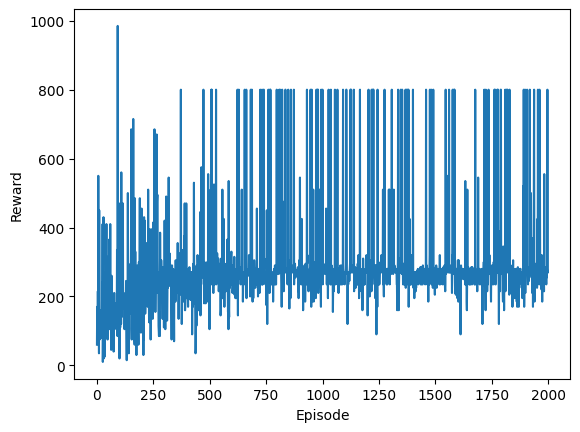

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores_ddqn)), scores_ddqn)
plt.ylabel('Reward')
plt.xlabel('Episode')
plt.show()

**Explanation of result obtained above**

The rewards obtained over episodes are also heavily fluctuating. This suggests that the DDDQN agent is having difficulties learning how to play the Space Invaders game.

In [ ]:
score = 0
frames = []
state = stack_frames(None, env.reset(), True)
while True:
    env.render(mode='rgb_array')
    action = agent_dddqn.act(state, .01)
    next_state, reward, done, _ = env.step(action)
    score += reward
    state = stack_frames(state, next_state, False)
    frames.append(env.render(mode='rgb_array'))
    if done:
        print("The Final score is:", score)
        break
env.close()

The Final score is: 290.0


In [ ]:
fileName = 'SpaceInvaders_DDDQN'
save_video(frames, './', fileName, 60, otype='AVI')

Creating replay Done saving to ./SpaceInvaders_DDQN.avi


## **Result**

DQN obtained a final score of 285, while DDDQN obtained a final score of 290. This suggests that DDDQN performs slightly better than DQN for playing Space Invaders game.



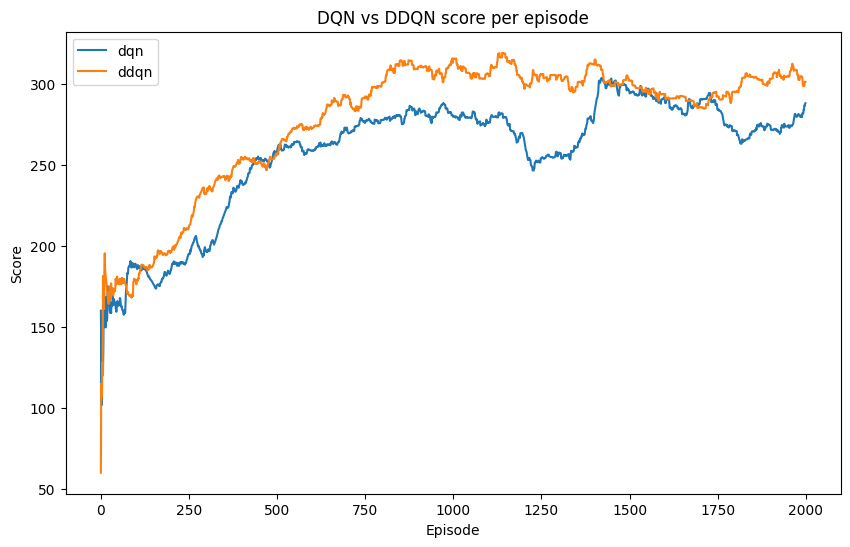

In [ ]:
# score per episode

plt.figure(figsize=(10,6))

# get moving average
N_dqn = len(scores_dqn)
N_ddqn = len(scores_ddqn)
running_avg_dqn = np.empty(N_dqn)
running_avg_ddqn = np.empty(N_ddqn)
for t in range(N_dqn):
    running_avg_dqn[t] = np.mean(scores_dqn[max(0, t-200):(t+1)])
for t in range(N_ddqn):
    running_avg_ddqn[t] = np.mean(scores_ddqn[max(0, t-200):(t+1)])

# do plot
plt.plot(range(len(running_avg_dqn)), running_avg_dqn, label='dqn')
plt.plot(range(len(running_avg_ddqn)), running_avg_ddqn, label='ddqn')
plt.xlabel('Episode')
plt.ylabel('Score')
plt.title(f'DQN vs DDQN score per episode')
plt.legend()
# plt.savefig(plots_path + output_dir + 'dqn_vs_ddqn_score_plot.png')
plt.show()

**Explanation of result obtained above**

The plotted graph shows the moving average of rewards per episode for both DQN and DDDQN agents. The results show that the DDDQN agent has a higher score than DQN in most of the episodes. This indicates that  DDDQN has a greater learning efficiency.

**Rainbow Algorithm**

To add on, the Rainbow algorithm is the extended version of DQN algorithm where it combined various improvements into one learner. It tackle the overestimation bias or prioritize important transitions. In addition, it uses distributional reinfrocemnt learning instead of the expected return. All of the mentioned improvements had greatly contributed to the algorithm’s ability in learning effectively by adapting the complexity of the multiplayer dynamics. It has outperformed other traditional reinfrocemnt learning approaches at it solved challenges mentioned previously. The full code is attached in the drive.

## **Discussion**

The reason for the DDDQN agent slightly outperforming DQN might be due to its ability to handle overestimation bias. DQN tends to overestimate the Q-values, which can cause suboptimal action selection during training. Besides, the combination of DDQN and Dueling DQN in DDDQN has a better action selection since it separates action selection and estimation of Q-values into two networks, which prevents the overestimation of Q-values affecting action selection. Furthermore, it separates the estimation of state values and action advantages. DDDQN not only reduces overestimation bias but also helps the agent generalize better across different states and actions and focus on learning the value of states independently of specific actions, leading to more efficient learning.

The agents' left and right movements in the videos indicate that the DDDQN agent has a better understanding of the environment and more effective exploration than the DQN agent. Both DQN and DDDQN agents have not learned effective strategies for avoiding enemy attacks. This could be due to the complexity of the game environment. Hence, more extensive exploration and training are needed to develop a defense strategy.

To further optimize the agents’ performance, hyperparameter tuning can be conducted on the learning rates, discount factors and exploration-exploitation schedules. Additionally, more complex neural network architecture can be used to obtain better results. Besides, a longer training durations is needed for the agents to learn a more effective strategy,

For the rainbow algorithmn, the agent had outperform the computer and won the game which indicates the algorithm had achieved the aim of itself.